# Домашнее задание по обработке текстов

Входные данные:
* Новости о компании "Газпром" с 2010 года

Часть 1. Вводная
Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:

Есть ли корреляция между средней длинной текста за день и ценой закрытия?
Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия? Учтите разные варианты написания имени.
Упоминаний какого газопровода в статьях больше:
"северный поток"
"турецкий поток"?
О каких санкциях пишут в статьях?

In [2]:
with open('gazprom.txt', encoding = 'utf-8') as f:
    raw = f.read()
    
news = raw.split('--------------------------------------------------------------------------')

len(news)

2393

In [3]:
news[-1]

'\n"Газпрому" не придется доплачивать за транзит газа через Украину\nАвторы: Vedomosti\nОпубликовано 04 Января 2010 в 23:51:00\n\nДоплата, которую "Газпром" должен сделать в связи с ростом тарифа на транзит, будет зачтена при оплате за приобретенный НАК "Нафтогаз Украины" газ, сообщил заместитель главы НАК Вадим Чупрун.'

Проведем преобразование дат в удобоваримый формат

In [4]:
import re

def month_to_num(word):
    months = ['января','февраля','марта','апреля','мая','июня','июля','августа','сентября','октября','ноября','декабря']
    res = months.index(word)+1
    if res < 10:
        res = '0'+str(res)
    return(str(res))

def extract_date(news):
    regexp_date = re.compile('Опубликовано\s[0-9]{1,2}\s[А-Яа-я]+\s201\d') 
    date_raw = regexp_date.findall(news)[0].lower().split()[1:]
    date = str(date_raw[0])+'.'+month_to_num(date_raw[1])+'.'+str(date_raw[2])
    return(date)

extract_date(news[0])

'09.11.2017'

Извлечем непосредственно тексты новостей

In [5]:
def extract_text(news):
    parts = news.split('\n')
    return (parts[0]+' '+parts[-2])

print(extract_text(news[0]))

Компания рассчитывает на решение по газовому спору с Украиной до конца декабря «Газпром» ожидает решения Стокгольмского арбитража по транзитному спору с украинским «Нафтогазом» не позднее февраля 2018 года, хотя раньше компания прогнозировала, что это произойдет до 30 ноября. Решение по взаимным искам об условиях поставок газа на Украину, по мнению монополии, суд может принять на месяц раньше — до декабря 2017 года.


In [6]:
events_by_date = {}

for n in news:
    date = extract_date(n)
    if date in events_by_date.keys():
        events_by_date[date] += ('\n'+extract_text(n))
    else:
        events_by_date[date] = extract_text(n)
    

In [7]:
import pandas as pd

df = pd.DataFrame.from_dict(events_by_date, orient='index')
df = df.reset_index()
df.columns = ['date', 'text']
df.to_csv('text.csv', index=False, encoding='utf-8')

In [8]:
articles = pd.read_csv('text.csv', encoding='utf-8')

In [9]:
articles.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [10]:
articles = articles.iloc[::-1]

In [11]:
articles.set_index('date', inplace=True)

In [12]:
articles.head()

,text
date,
04.01.2010,
11.01.2010,Спорные вопросы по оплате за оказанные в пери...
19.01.2010,"""Газпром"" готов забирать весь объем азербайдж..."
28.01.2010,"Консорциум во главе с российским ОАО ""Газпром..."
01.02.2010,"""Газпром"" не исключает в 2010 г. выпуска обли..."


Используем регулярные выражения, чтобы разбить тексты на слова

In [13]:
import re
regex = re.compile("[А-Яа-я----]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


articles.text = articles.text.str.lower()
articles.text = articles.text.apply(words_only)

посмотрим на самые частые слова, встречающиеся в текстах

In [14]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in articles.iterrows():
    tokens = row['text'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('в', 5510)
('на', 3126)
('газпром', 2552)
('и', 2436)
('по', 1600)
('с', 1455)
('не', 1033)
('газа', 961)
('млрд', 906)
('что', 824)


Удалим стоп-слова

In [15]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', '-', 'г', 'гг']

print(mystopwords)
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
articles.text = articles.text.apply(remove_stopwords)  

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [16]:
articles.head()

,text
date,
04.01.2010,
11.01.2010,спорные вопросы оплате оказанные период услуги...
19.01.2010,газпром готов забирать весь объем азербайджанс...
28.01.2010,консорциум главе российским оао газпром нефть ...
01.02.2010,газпром исключает выпуска облигаций примерно п...


Проведем лемматизацию (к сожалению, pymystem не работает корректно на моему компьютере, поэтому использую pymorphy, качество страдает, видно невообруженным глазом).

In [17]:
%%time
from pymorphy2 import MorphAnalyzer

m = MorphAnalyzer()

lemmas1 = [m.parse(word)[0].normal_form for word in articles.text]

t = ' '.join(lemmas1)
print(t)

 спорные вопросы оплате оказанные период услуги транспортировке природного газа территории польши должны урегулированы основе принципа отсутствия взаимных претензий переговоры продолжаются сообщили риа новости управлении информации оао газпром газпром обещает покупать году весь газ который захочет экспортировать азербайджан потенциальный поставщик сырья конкурирующего российским газопроводом южный поток проекта набукко газпром готов забирать весь объем азербайджанского газа баку готов поставить заявил вторник глава газпрома алексей миллер специфика контракта азербайджаном заключается предела верхнего закупкам газа единственный контракт газпрома записаны такие условия готовы забирать столько газа азербайджанского сколько наши азербайджанские коллеги готовы поставить сказал миллер консорциум главе российским оао газпром нефть четверг подписал контракт разработку месторождения бадра ираке говорится сообщении компании контракт правительством ирака подписал заместитель генерального директор

In [18]:
articles.head()

,text
date,
04.01.2010,
11.01.2010,спорные вопросы оплате оказанные период услуги...
19.01.2010,газпром готов забирать весь объем азербайджанс...
28.01.2010,консорциум главе российским оао газпром нефть ...
01.02.2010,газпром исключает выпуска облигаций примерно п...


In [19]:
#%%time 
#from pymystem3 import Mystem

#m = Mystem()
#def lemmatize(text, mystem=m):
 #   try:
  #      return "".join(m.lemmatize(text)).strip()  
   # except:
    #    return " "

#df.text = df.text.apply(lemmatize)

In [20]:
prices = pd.read_csv('gazprom_prices.csv', sep=';', encoding='utf-8')
prices = prices.iloc[::-1]
prices.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
1987,11.01.2010,"192,50000","194,50000","196,90000","191,00000",59815603
1986,12.01.2010,"194,00000","191,80000","195,80000","190,55000",43482579
1985,13.01.2010,"189,72000","189,30000","191,86000","188,30000",52416087
1984,14.01.2010,"191,20000","190,83000","191,46000","188,88000",41207109
1983,15.01.2010,"190,00000","187,86000","192,10000","187,25000",55571965


In [21]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 1987 to 0
Data columns (total 6 columns):
Date            1988 non-null object
Open            1964 non-null object
ClosingPrice    1988 non-null object
DailyHigh       1986 non-null object
DailyLow        1986 non-null object
VolumePcs       1988 non-null int64
dtypes: int64(1), object(5)
memory usage: 93.3+ KB


In [22]:
pr = prices[prices.Date.isin(articles.index)]
pr.set_index('Date', inplace=True)
pr

,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
Date,,,,,
11.01.2010,"192,50000","194,50000","196,90000","191,00000",59815603
19.01.2010,"190,10000","189,76000","190,47000","187,36000",48626727
28.01.2010,"183,75000","182,30000","185,98000","181,67000",62561241
01.02.2010,"184,74000","189,85000","190,40000","183,50000",76298175
03.02.2010,"194,00000","192,70000","195,27000","192,30000",74730185
04.02.2010,"192,60000","186,59000","193,39000","185,78000",72663606
15.02.2010,"163,52000","164,45000","165,16000","162,50000",40268788
10.03.2010,"174,80000","173,77000","177,71000","172,65000",64149524
22.03.2010,"166,34000","169,29000","169,64000","164,89000",68318812


Для некоторых дат нет цен, удалим тексты за эти даты за датасета с новостями.

In [23]:
articles = articles[articles.index.isin(pr.index)]
articles

,text
date,
11.01.2010,спорные вопросы оплате оказанные период услуги...
19.01.2010,газпром готов забирать весь объем азербайджанс...
28.01.2010,консорциум главе российским оао газпром нефть ...
01.02.2010,газпром исключает выпуска облигаций примерно п...
03.02.2010,переговоры оао газпром оператором проекта саха...
04.02.2010,российский газовый монополист компания газпром...
15.02.2010,российский газпром сообщил планах увеличения д...
10.03.2010,подконтрольный газпрому нефтедобытчик газпром ...
22.03.2010,газпром назвал участников конкурса отбору орга...


In [24]:
articles.columns = ['text']

Посмотрим на среднюю длину текстов

In [25]:
from bokeh.charts import Bar, output_notebook, show
import math
output_notebook()

Loading BokehJS ...

In [26]:
len_data = articles.text.apply(len)
len_data.describe()

count    1159.000000
mean      629.251941
std       445.610619
min        65.000000
25%       332.000000
50%       482.000000
75%       803.000000
max      3254.000000
Name: text, dtype: float64

In [27]:
from bokeh.charts import Histogram
hist = Histogram(len_data[len_data < 10000])
show(hist)

In [28]:
import seaborn as sns
%pylab inline
%config InlineBackend.figure_format = 'svg' 

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist', 'f', 'show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Посмотрим, существует ли взаимосвязь между средней длинной текста за день и ценой закрытия

In [29]:
correlation = pd.concat([pr['ClosingPrice'], articles['text']], axis=1, keys=['ClosingPrice', 'text'])

correlation['text_length']  = correlation['text'].str.len()
correlation['ClosingPrice'] = correlation['ClosingPrice'].str.replace(',','.')
correlation.ClosingPrice= pd.to_numeric(correlation.ClosingPrice)
correlation.sort_values(by = ['ClosingPrice'])


,ClosingPrice,text,text_length
24.06.2013,107.17,стать партнером газпрома строительству завода ...,617
27.06.2013,107.75,немецкая первой европейских компаний суд добил...,754
21.06.2013,108.05,пмэф газпром подписал итальянской протокол нам...,1274
20.06.2013,108.36,переговоры газпрома китайской поставках газа к...,350
28.06.2013,108.85,газпром скорректирует цены немецкой мая май ск...,1607
25.06.2013,108.89,попытках спасти неэффективные алюминиевые заво...,445
01.07.2013,108.98,газпром вновь пугает европу сбоями поставках г...,329
03.07.2013,109.06,приватизация московской объединенной энергетич...,969
14.06.2013,109.91,третий величине российский банк газпромбанк кв...,150
26.06.2013,110.12,газпром заблокировал попытку немецкой нак нафт...,372


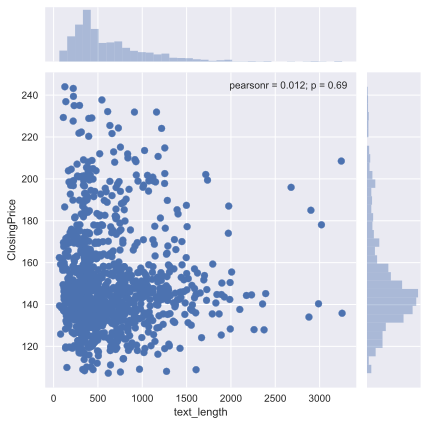

In [30]:
sns.jointplot(x='text_length', y='ClosingPrice', 
              data=correlation, kind='scatter');

Корреляции нет

Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия? Учтите разные варианты написания имени.

In [31]:
import re

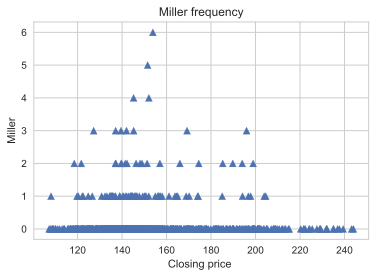

In [84]:
def find_miller(line):
    p = re.compile(r'миллер[\S]*?')
    return len(p.findall(line))

x = [float(y) for y in correlation.ClosingPrice]
y = [find_miller(x) for x in correlation.text]
plt.style.use('seaborn-whitegrid')
plt.title('Miller frequency')
plt.xlabel('Closing price ')
plt.ylabel('Miller')
plt.scatter(x,y, marker='^')

корреляция также не наблюдается

Посмотрим, сколько раз в статьях упомянаются северный и турецкий потоки

In [33]:
prog = re.compile('[А-Яа-я\-]+')
tokens = prog.findall(t)

In [34]:
import nltk

d1 = nltk.FreqDist(tokens)
d1.most_common(10)

[('газпром', 2570),
 ('газа', 946),
 ('компании', 684),
 ('руб', 596),
 ('газпрома', 541),
 ('нефть', 462),
 ('компания', 397),
 ('нефти', 345),
 ('года', 345),
 ('газ', 344)]

In [35]:
res1 = re.findall(r'турецк[\S]*? поток[\S]*?', t)
print(res1)

['турецкий поток', 'турецкого поток', 'турецкого поток', 'турецкий поток', 'турецкому поток', 'турецкого поток', 'турецкий поток', 'турецкий поток', 'турецком поток', 'турецкого поток', 'турецкий поток', 'турецкий поток', 'турецкий поток', 'турецкий поток', 'турецкий поток', 'турецкого поток', 'турецкий поток', 'турецкого поток', 'турецкий поток', 'турецкого поток', 'турецкий поток', 'турецкого поток', 'турецкий поток', 'турецким поток', 'турецкий поток', 'турецкий поток', 'турецкого поток', 'турецкого поток', 'турецкий поток', 'турецкого поток', 'турецкого поток', 'турецкого поток', 'турецкому поток', 'турецкого поток', 'турецкий поток', 'турецкого поток', 'турецкого поток', 'турецкого поток', 'турецкого поток']


In [36]:
print(len(res1))

39


In [37]:
res2 = re.findall(r'северн[\S]*? поток[\S]*?', t)
print(res2)

['северный поток', 'северный поток', 'северный поток', 'северного поток', 'северный поток', 'северный поток', 'северный поток', 'северного поток', 'северного поток', 'северный поток', 'северный поток', 'северного поток', 'северный поток', 'северного поток', 'северный поток']


In [38]:
print(len(res2))

15


Турецкий поток упоминается чаще северного

Попробуем посмотреть, о каких санкциях говорится в статьях

In [139]:
with open('gazprom2.txt', encoding = "utf-8") as f:
    raw = f.read()

In [140]:

tokens = nltk.word_tokenize(raw)
nltk_text = nltk.Text(tokens)
nltk_text

<Text: ﻿Компания рассчитывает на решение по газовому спору с...>

In [151]:
nltk_text.concordance("санкций")

Displaying 25 of 50 matches:
3:21:35 Новая редакция американских санкций ставит под угрозу зарубежные нефтян
ком интересовалась Shell , но из-за санкций иностранцы с 2014 года на шельф Рос
ком интересовалась Shell , но из-за санкций иностранцы с 2014 года на шельф Рос
 не наблюдалось , в том числе из-за санкций . Эксперты полагают , что в силу оп
 не наблюдалось , в том числе из-за санкций . Эксперты полагают , что в силу оп
нгодатели не почувствовали западных санкций , “ Ъ ” рассказал гендиректор « Газ
 правомерность введенных Советом ЕС санкций в отношении « Роснефти » . Брюссель
компании ищут способы спрятаться от санкций Авторы : Kommersant , Ольга Мордюше
16 в 00:00:00 '' Газпром '' на фоне санкций начинает предпринимать реальные дей
-- -- -- -- -- -- -- Из-за западных санкций Авторы : Kommersant , Юрий Барсуков
ество уже заморожено из-за западных санкций против банка , `` Владивосток СПГ '
аховку на случай введения очередных санкций . Перевод расчетов за экспорт росси
мятся связы

In [152]:
nltk_text.concordance("санкции")

Displaying 25 of 30 matches:
- -- -- -- -- -- США распространили санкции на зарубежные проекты российских не
 -- « Роснефть » не смогла отменить санкции в Суде Евросоюза Авторы : Kommersan
ского месторождения , попавшего под санкции . По мнению экспертов , пока речь м
этом направлении серьезно осложняют санкции США . -- -- -- -- -- -- -- -- -- --
-- -- -- -- -- -- -- -- -- -- -- -- Санкции США бьют по стратегическим партнера
ом '' , который до сих пор западные санкции почти не затрагивали , впервые попа
- -- -- -- -- -- -- -- -- -- Мешают санкции и политические риски Авторы : Komme
 , так и подпавшие под персональные санкции РНКБ , СМП банк и банк « Россия » ,
0:00:00 '' Газпром '' , несмотря на санкции и проблемы с привлечением финансиро
3:00 '' Газпром '' не ожидает , что санкции окажут значительное влияние на фина
 в договоры с подрядчиками штрафные санкции за несогласованные публикации о зак
- -- -- -- -- '' Газпром нефть '' : Санкции существенно не повлияют на финансов
- -- -- -- 

В текстах говорится о санкциях США и ЕС, западные санкции, против Газпрома, Роснефти, госбанков, РФ.

Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия. Для этого:

бинаризуйте признак "цена закрытия": новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.
Таким образом, в каждлый момент времени мы знаем:

ClosingPrice_bin – бинарый целевой признак
слова из статей, опубликованных в этот день – объясняющие признаки
В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части.

Используйте любой известный вам алгоритм классификации текстов для того, Используйте  tf−idftf−idf  преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  tf−idftf−idf  преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации. Если у выбранного вами алгоритма есть гиперпараметры (например,  αα  в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [39]:
correlation2 = correlation.reset_index()

In [40]:
import numpy as np

ClosingPrice_bin = np.array(correlation2['ClosingPrice'])
ClosingPrice_bin[:10]

array([ 189.85,  204.91,  185.54,  142.41,  133.9 ,  149.65,  194.01,
        133.85,  135.89,  147.2 ])

In [41]:
len(ClosingPrice_bin)

1159

In [42]:
articles.shape

(1159, 1)

In [49]:
ClosingPrice_bin = [0]
for i in range(1,len(correlation2)):
    price1 = list(correlation2.ClosingPrice)[i-1]
    price2 = list(correlation2.ClosingPrice)[i]
    if price1 <= price2:
        ClosingPrice_bin.append(1)
    else:
        ClosingPrice_bin.append(0)

In [50]:
correlation2['ClosingPrice_bin'] = ClosingPrice_bin

In [482]:
ClosingPrice_bin[-1] = 1
ClosingPrice_bin
y = ClosingPrice_bin.astype('int')

In [62]:
import dateutil

In [63]:
from datetime import datetime

In [64]:
correlation2['index'] = correlation2['index'].apply(dateutil.parser.parse)

In [65]:
split_date = datetime.strptime('2016-01-01', '%Y-%m-%d')

In [66]:
train_data = correlation2[correlation2['index'] < split_date]
test_data = correlation2[correlation2['index'] >= split_date]

In [67]:
train_data.head()

,index,ClosingPrice,text,text_length,ClosingPrice_bin
0,2010-01-02,189.85,газпром исключает выпуска облигаций примерно п...,218,0
1,2011-01-02,204.91,российском тв вновь дефицит рекламного времени...,445,1
2,2012-01-02,185.54,федеральная антимонопольная служба фас признал...,704,0
3,2013-01-02,142.41,правительство выдвинуло кандидатов мест совете...,146,0
6,2012-01-03,194.01,газпром скорректирует условия поставок российс...,754,1


In [68]:
test_data.head()

,index,ClosingPrice,text,text_length,ClosingPrice_bin
4,2016-01-02,133.90,газпром исключил участия реализации экспортных...,1003,0
5,2017-01-02,149.65,сегодня исследовательская компания опубликовал...,772,1
7,2017-01-03,133.85,правление газпрома предложило сохранить дивиде...,921,0
9,2016-01-04,147.20,газпром-медиа управляющий телеканалами тнт нтв...,650,1
11,2016-01-06,144.70,директор входящего газпром-медиа телеканала тн...,631,1


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [89]:
vectorizer = CountVectorizer(ngram_range=(1,4), max_features=40000)

train_v = vectorizer.fit_transform(list(train_data.text))
test_v = vectorizer.fit_transform(list(test_data.text))

In [90]:
train_v

<901x40000 sparse matrix of type '<class 'numpy.int64'>'
	with 95867 stored elements in Compressed Sparse Row format>

In [91]:
test_v

<258x40000 sparse matrix of type '<class 'numpy.int64'>'
	with 48874 stored elements in Compressed Sparse Row format>

In [92]:
X_train = train_v
X_test = test_v
y_train = train_data.ClosingPrice_bin
y_test = test_data.ClosingPrice_bin

In [93]:
X_train

<901x40000 sparse matrix of type '<class 'numpy.int64'>'
	with 95867 stored elements in Compressed Sparse Row format>

In [94]:
X_test

<258x40000 sparse matrix of type '<class 'numpy.int64'>'
	with 48874 stored elements in Compressed Sparse Row format>

Попробуем построить несколько классификационных моделей и сравнить их качество

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [100]:
clf1 = LogisticRegression()
clf1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [102]:
preds = clf1.predict(X_test)
print(preds)

[1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1
 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1
 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1
 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0]


In [103]:
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.70      0.32      0.44       167
          1       0.37      0.75      0.50        91

avg / total       0.58      0.47      0.46       258



In [104]:
from sklearn.svm import LinearSVC

clf2 = LinearSVC()
clf2.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [106]:
preds2 = clf2.predict(X_test)
print(list(preds2))

[1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]


In [107]:
print(classification_report(y_test, preds2))

             precision    recall  f1-score   support

          0       0.70      0.34      0.46       167
          1       0.38      0.74      0.50        91

avg / total       0.59      0.48      0.47       258



In [109]:
clf3 = MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [110]:
clf3.fit(X_train, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [111]:
preds3 = clf3.predict(X_test)
print(list(preds3))

[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]


In [112]:
print(classification_report(y_test, preds3))

             precision    recall  f1-score   support

          0       0.69      0.41      0.51       167
          1       0.38      0.66      0.48        91

avg / total       0.58      0.50      0.50       258

